# Auto ML

In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import utils.eda_utils as eda_utils 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
import numpy as np

d:\rockhead_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('data/240907_Rockhead_Seoul_train(false, before_aumentation).csv')
val_df = pd.read_csv('data/240907_Rockhead_Seoul_val(false, before_aumentation).csv')
test_df = pd.read_csv('data/240907_Rockhead_Seoul_test(false, before_aumentation).csv')

C:\Users\user\AppData\Local\Temp\ipykernel_70052\1112063775.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, test_df, train_df, val_df])


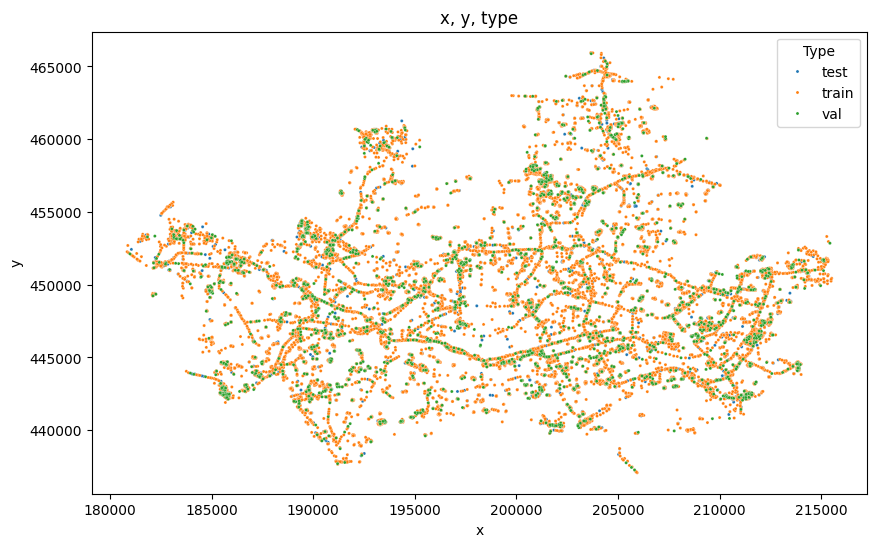

In [3]:
train_df['Type'] = 'train'
val_df['Type'] = 'val'
test_df['Type'] = 'test'

df_concat = pd.DataFrame(columns=train_df.columns)
df_concat = pd.concat([df_concat, test_df, train_df, val_df])

eda_utils.scatter_relation(df_concat, 'x', 'y', 5, 'x, y, type','Type')

## Data Cleansing
- delete: depth end, borehole_code
- replace: ground name
- normalization: x, y, elevation, density

In [4]:
# replace

def df_cleansing(df):

    # replace
    ground_name_map = {'WR':0, 'SR': 1, 'MR': 2, 'HR': 3}
    df['Ground name'] = df['Ground name'].map(ground_name_map)
    df['Ground name'] = df['Ground name'].astype('category')

    # delete
    df = df.drop('depth_end', axis=1)
    df = df.drop('borehole_code', axis=1)
    df = df.drop('Type', axis=1)
    df = df.drop('Density', axis=1)

    return df

In [5]:
train_df = df_cleansing(train_df)
val_df = df_cleansing(val_df)
test_df = df_cleansing(test_df)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   x            16313 non-null  float64 
 1   y            16313 non-null  float64 
 2   elevation    16313 non-null  float64 
 3   depth_start  16313 non-null  float64 
 4   Ground name  16313 non-null  category
dtypes: category(1), float64(4)
memory usage: 526.0 KB


In [7]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   x            2024 non-null   float64 
 1   y            2024 non-null   float64 
 2   elevation    2024 non-null   float64 
 3   depth_start  2024 non-null   float64 
 4   Ground name  2024 non-null   category
dtypes: category(1), float64(4)
memory usage: 65.6 KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2022 entries, 0 to 2021
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   x            2022 non-null   float64 
 1   y            2022 non-null   float64 
 2   elevation    2022 non-null   float64 
 3   depth_start  2022 non-null   float64 
 4   Ground name  2022 non-null   category
dtypes: category(1), float64(4)
memory usage: 65.5 KB


## Training-Validation

In [9]:
train = TabularDataset(pd.concat([train_df, val_df]))
test = TabularDataset(test_df.drop(['depth_start'], axis=1))
y_test = test_df['depth_start'].values.tolist()

In [10]:
hyperparameter_tune_kwargs = {  
    'num_trials': 45,
    'scheduler' : 'local',
    'searcher': 'auto',
}

predictor = TabularPredictor(label='depth_start', 
                             problem_type = 'regression', 
                             eval_metric='r2',
                             verbosity =2
                             )

predictor.fit(train,
              num_gpus=1,
              time_limit = 36000, 
              hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,  
              presets="good_quality", 
              save_space = True, 
              keep_only_best = True,
              save_bag_folds = False
              )

2024-09-08 17:48:44,184	INFO timeout.py:54 -- Reached timeout of 1678.4304291009903 seconds. Stopping all trials.
2024-09-08 17:48:44,201	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to 'D:/rockhead_prediction/AutogluonModels/ag-20240908_010748/models/NeuralNetTorch_BAG_L2' in 0.0140s.
2024-09-08 17:48:50,171	WARNING experiment_analysis.py:190 -- Failed to fetch metrics for 5 trial(s):
- 5c11048f: FileNotFoundError('Could not fetch metrics for 5c11048f: both result.json and progress.csv were not found at D:/rockhead_prediction/AutogluonModels/ag-20240908_010748/models/NeuralNetTorch_BAG_L2/5c11048f')
- 59ea2a7d: FileNotFoundError('Could not fetch metrics for 59ea2a7d: both result.json and progress.csv were not found at D:/rockhead_prediction/AutogluonModels/ag-20240908_010748/models/NeuralNetTorch_BAG_L2/59ea2a7d')
- b1dc121a: FileNotFoundError('Could not fetch metrics for b1dc121a: both result.json and progress.csv were not found at D:/rockhea

In [11]:
ld_board = predictor.leaderboard(train, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_BAG_L2\59ea2a7d_FULL,0.965417,None,r2,376.242977,NaN,1469.848089,0.254044,NaN,50.015204,2,True,127
1,NeuralNetTorch_BAG_L2\5c11048f_FULL,0.963558,None,r2,376.116955,NaN,1442.911901,0.128022,NaN,23.079015,2,True,126
2,NeuralNetFastAI_BAG_L2\7b0e9bd0_FULL,0.962508,None,r2,376.295486,NaN,1438.317102,0.306553,NaN,18.484216,2,True,122
3,WeightedEnsemble_L3_FULL,0.961566,None,r2,378.793608,NaN,1666.415293,0.013002,NaN,0.227041,3,True,128
4,NeuralNetFastAI_BAG_L2\2980a5e8_FULL,0.959071,None,r2,376.408006,NaN,1437.036378,0.419073,NaN,17.203493,2,True,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,NeuralNetFastAI_BAG_L1\ce890360_FULL,0.322568,None,r2,0.094016,NaN,6.678662,0.094016,NaN,6.678662,1,True,96
124,NeuralNetFastAI_BAG_L1\15f734ca_FULL,0.290833,None,r2,0.344060,NaN,6.275592,0.344060,NaN,6.275592,1,True,97
125,NeuralNetFastAI_BAG_L1\fb9ace41_FULL,0.275565,None,r2,0.348060,NaN,17.988631,0.348060,NaN,17.988631,1,True,90
126,NeuralNetFastAI_BAG_L1\44c79035_FULL,0.162511,None,r2,0.091516,NaN,4.998870,0.091516,NaN,4.998870,1,True,84


## Prediction

In [12]:
pred_y = predictor.predict(test)

In [13]:
mae = mean_absolute_error(y_test, pred_y)
mse = mean_squared_error(y_test, pred_y)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_y)

print('mae: ',mae)
print('mse: ',mse)
print('rmse: ',rmse)
print('r2: ',r2) #1에 가까울수록 좋음

mae:  2.177571911446301
mse:  10.572056921409049
rmse:  3.2514699631718957
r2:  0.7934449118643313
